In [43]:
# Lab 05– Classification Models &amp; Ensemble Evaluation
# Learning Outcomes
# By the end of this lab, students will be able to:
# Train decision tree (using library and from scratch)
# Evaluate models using accuracy, ROC AUC, and confusion matrix.
# Interpret trade-offs between models.
# P — Project

# Preprocess Churn dataset (encoding, scaling).
# Train/test split.
# Fit:
# Decision Tree
# Evaluate all models with metrics table &amp; ROC curves.
# Save best model.
# Resources
# Sklearn Model Evaluation – https://scikitlearn. org/stable/modules/model_evaluation.html
# Confusion Matrix in Sklearn – https://scikitlearn.
# org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import joblib
import warnings

# Load the dataset
df = pd.read_csv('LabAssig5_stuff/churn.csv')

In [45]:
# --- 1. Preprocess Churn dataset (encoding, scaling) ---
print("--- 1. Preprocessing Data ---")

dataset_path = "LabAssig5_stuff/churn.csv"

df = pd.read_csv(dataset_path)
df = df.dropna(subset=["Churn"])

# Normalize to binary int
df["Churn"] = df["Churn"].astype(str).str.strip()
y = df["Churn"].map({
    True: 1, False: 0,
    "True": 1, "False": 0,
    "Yes": 1, "No": 0,
    "Y": 1, "N": 0,
    "1": 1, "0": 0
}).astype(int)

X = df.drop(columns=["Churn"])
print("Shape:", df.shape)
display(df.head(3))

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Handle all-NaN or empty
if len(num_cols) == 0 and len(cat_cols) == 0:
    raise ValueError("No usable feature columns found.")

num_transformer = StandardScaler()

try:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols) if len(num_cols) else ("num", "drop", []),
        ("cat", cat_transformer, cat_cols) if len(cat_cols) else ("cat", "drop", []),
    ],
    remainder='passthrough'
)

print(f"# numeric: {len(num_cols)}, # categorical: {len(cat_cols)}")


--- 1. Preprocessing Data ---
Shape: (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True


# numeric: 16, # categorical: 3


In [46]:
# --- 2. Splitting Data and Scaling Features ---
print("--- 2. Splitting Data and Preparing for Scaling ---")

# First, split the raw, unscaled data into training and testing sets
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.\n")

# Now, prepare the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train)

# Use the fitted scaler to transform both the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete. The scaler was fit on the training data and applied to both sets.")


--- 2. Splitting Data and Preparing for Scaling ---
Data split into 800 training and 200 testing samples.

Scaling complete. The scaler was fit on the training data and applied to both sets.


In [47]:
# 3. Fit Decision Tree
print("--- 3. Training Decision Tree Model ---")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
print("Decision Tree model trained successfully.\n")

--- 3. Training Decision Tree Model ---
Decision Tree model trained successfully.



--- 4. Evaluating Model ---
Metrics Table:
     Metric  Decision Tree
0  Accuracy       0.540000
1   ROC AUC       0.539586

Confusion Matrix (Decision Tree):
[[57 46]
 [46 51]]


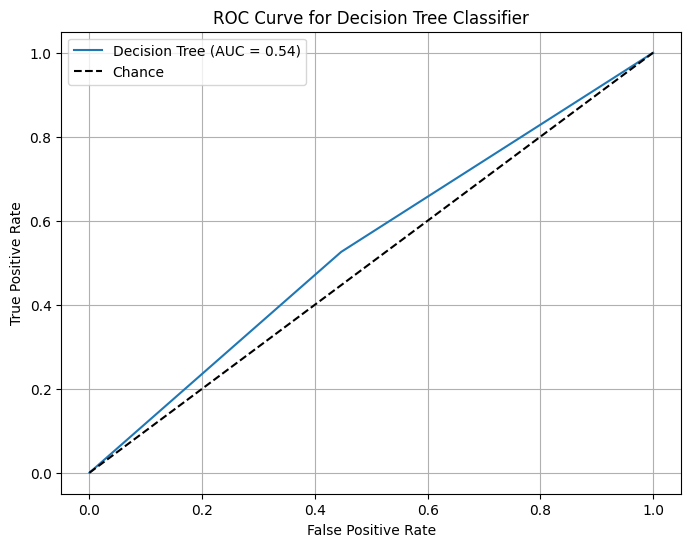

Evaluation complete.



In [48]:
# 4. Evaluate all models with metrics table & ROC curves
print("--- 4. Evaluating Model ---")

# Make predictions
y_pred_dt = dt_classifier.predict(X_test)
y_proba_dt = dt_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Create metrics table
metrics_data = {
    'Metric': ['Accuracy', 'ROC AUC'],
    'Decision Tree': [accuracy_dt, roc_auc_dt]
}
metrics_df = pd.DataFrame(metrics_data)

print("Metrics Table:")
print(metrics_df)
print("\nConfusion Matrix (Decision Tree):")
print(conf_matrix_dt)

# Plot ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend()
plt.grid(True)
plt.show()
print("Evaluation complete.\n")



In [49]:
# 5. Save best model
print("--- 5. Saving Model ---")
# In this case, we only have one model, so we save it.
model_filename = 'decision_tree_model_lab6.joblib'
joblib.dump(dt_classifier, model_filename)
print(f"Model saved as '{model_filename}'.")

--- 5. Saving Model ---
Model saved as 'decision_tree_model_lab6.joblib'.
